# Calculate density and velocity gradients

In [1]:
# Jupyter Notebook with widget matplotlib plots
#%matplotlib notebook
# Jupyter Lab with widget matplotlib plots
#%matplotlib widget 
# with Jupyter and Jupyter Lab but without widget matplotlib plots
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import sys
import pyicon as pyic
import cartopy
import seawater as sw

In [75]:
ccrs_proj = cartopy.crs.PlateCarree()

## Specify data set

In [76]:
run = 'nib0004'
runname = 'icon_08'
gname = 'r2b6'
lev = 'L64'

path_data     = f'/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/{runname}/icon-oes/experiments/{run}/'
path_grid     = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
path_ckdtree  = f'{path_grid}ckdtree/'
fpath_ckdtree = f'{path_grid}ckdtree/rectgrids/{gname}_res0.30_180W-180E_90S-90N.npz'
fpath_fx      = f'{path_grid}{gname}_{lev}_fx.nc'

In [17]:
IcD = pyic.IconData(
    fname        = run+'_????????????????.nc',
    path_data    = path_data,
    path_grid    = path_grid,
    gname        = gname,
    lev          = lev,
    do_triangulation    = True,
    omit_last_file      = False,
    calc_coeff          = True,
    calc_coeff_mappings = True,
              )

Start with calc_coeff...
Done with calc_coeff!
Start with calc_coeff_mappings...
--- fixed_vol_norm
--- edge2edge_viacell_coeff
--- edge2cell_coeff_cc
--- edge2cell_coeff_cc_t
Done with calc_coeff_mappings!


In [171]:
t1 = '2100-02-01'
t2 = '2150-01-01'

## Load data

In [ ]:
# --- load data
uo, it_ave   = pyic.time_average(IcD, 'u', t1=t1, t2=t2, iz='all')
vo, it_ave   = pyic.time_average(IcD, 'v', t1=t1, t2=t2, iz='all')
to, it_ave   = pyic.time_average(IcD, 'to', t1=t1, t2=t2, iz='all')
so, it_ave   = pyic.time_average(IcD, 'so', t1=t1, t2=t2, iz='all')
rho_pot = sw.dens(so, to, 0.)
b = -IcD.grav*(rho_pot-IcD.rho0)/IcD.rho0
# b = rho_pot-1000.
b[IcD.wet_c==0.] = np.ma.masked

In [120]:
rhop1 = sw.dens(so[1:,:], to[1:,:], IcD.depthi[1:-1,np.newaxis])
rhom1 = sw.dens(so[:-1,:], to[:-1,:], IcD.depthi[1:-1,np.newaxis])

In [119]:
N2 = np.ma.zeros((IcD.nz+1,to.shape[1]))
N2[1:-1,:] = - (rhom1-rhop1)/IcD.dzt[1:-1,:] * IcD.grav/IcD.rho0
N2[:-1,:] *= IcD.wet_c

In [121]:
N2vi = 0.5*(N2[1:,:]+N2[:-1,:])
N2vi *= IcD.wet_c

In [135]:
gradh_b = (b[:,IcD.adjacent_cell_of_edge[:,1]]-b[:,IcD.adjacent_cell_of_edge[:,0]])*IcD.grad_coeff
p_gradh_b = pyic.edges2cell(IcD, gradh_b)
dbdx, dbdy = pyic.calc_2dlocal_from_3d(IcD, p_gradh_b)

In [154]:
gradh_u = (uo[:,IcD.adjacent_cell_of_edge[:,1]]-uo[:,IcD.adjacent_cell_of_edge[:,0]])*IcD.grad_coeff
gradh_v = (vo[:,IcD.adjacent_cell_of_edge[:,1]]-vo[:,IcD.adjacent_cell_of_edge[:,0]])*IcD.grad_coeff
p_gradh_u = pyic.edges2cell(IcD, gradh_u)
p_gradh_v = pyic.edges2cell(IcD, gradh_v)
dudx, dudy = pyic.calc_2dlocal_from_3d(IcD, p_gradh_u)
dvdx, dvdy = pyic.calc_2dlocal_from_3d(IcD, p_gradh_v)

In [160]:
dudz = np.ma.zeros((IcD.nz+1,uo.shape[1]))
dudz[1:-1,:] = (uo[:-1,:]-uo[1:,:])/IcD.dzt[1:-1,:]
dudz[:-1,:] *= IcD.wet_c
dvdz = np.ma.zeros((IcD.nz+1,vo.shape[1]))
dvdz[1:-1,:] = (vo[:-1,:]-vo[1:,:])/IcD.dzt[1:-1,:]
dvdz[:-1,:] *= IcD.wet_c

In [163]:
dudzvi = 0.5*(dudz[1:,:]+dudz[:-1,:])
dudzvi *= IcD.wet_c
dvdzvi = 0.5*(dvdz[1:,:]+dvdz[:-1,:])
dvdzvi *= IcD.wet_c

## Plot density gradients

In [137]:
lon, lat, bi = pyic.interp_to_rectgrid(b, fpath_ckdtree, coordinates='clat clon')
lon, lat, dbdxi = pyic.interp_to_rectgrid(dbdx, fpath_ckdtree, coordinates='clat clon')
lon, lat, dbdyi = pyic.interp_to_rectgrid(dbdy, fpath_ckdtree, coordinates='clat clon')

In [138]:
lon, lat, N2vihi = pyic.interp_to_rectgrid(N2vi, fpath_ckdtree, coordinates='clat clon')

In [139]:
# choose depth level
iz = np.argmin((IcD.depthc-300.)**2)

In [85]:
bi.shape

(64, 600, 1200)

In [86]:
bi[iz,:,:].max()

0.0789172354027589

In [141]:
dbdxi[iz,:,:].max()

8.904381944376876e-08

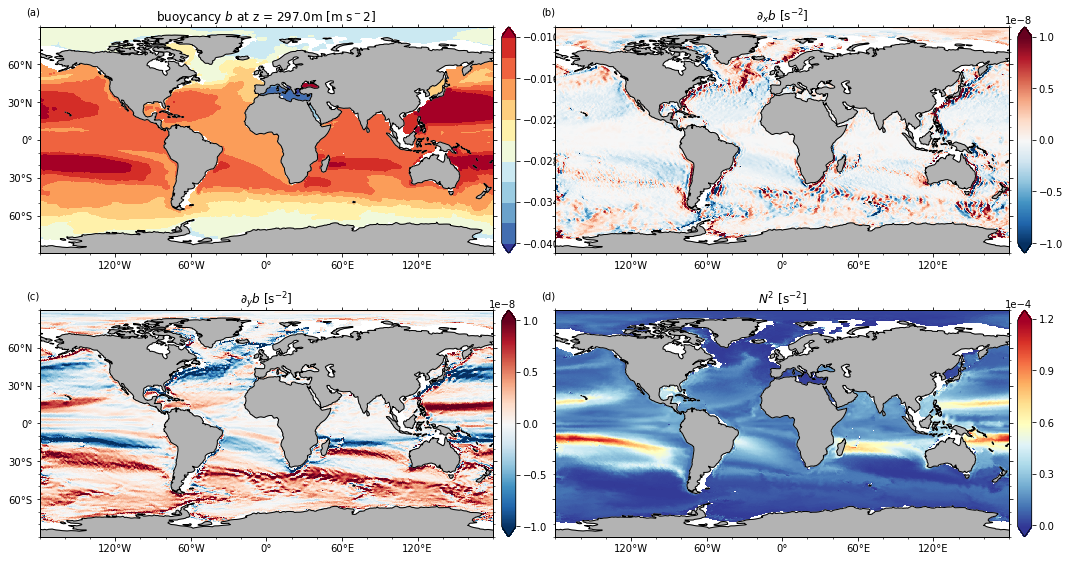

In [142]:
hca, hcb = pyic.arrange_axes(2,2, plot_cb=True, asp=0.5, fig_size_fac=2.,
                               sharex=False, sharey=True, xlabel="", ylabel="",
                               projection=ccrs_proj,
                            )
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, bi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=[-0.04,-0.01], contfs='21' 
               )
ax.set_title(f'buoycancy $b$ at z = {IcD.depthc[iz]:.1f}m [m s$^{-2}$]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, dbdxi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=1e-8, 
               )
ax.set_title('$\partial_x b$ [s$^{-2}$]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, dbdyi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=1e-8, 
               )
ax.set_title('$\partial_y b$ [s$^{-2}$]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, N2vihi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim='auto', 
               )
ax.set_title('$N^2$ [s$^{-2}$]')

for ax in hca:
    pyic.plot_settings(ax, template='global')

In [143]:
ix = np.argmin((lon+30)**2)

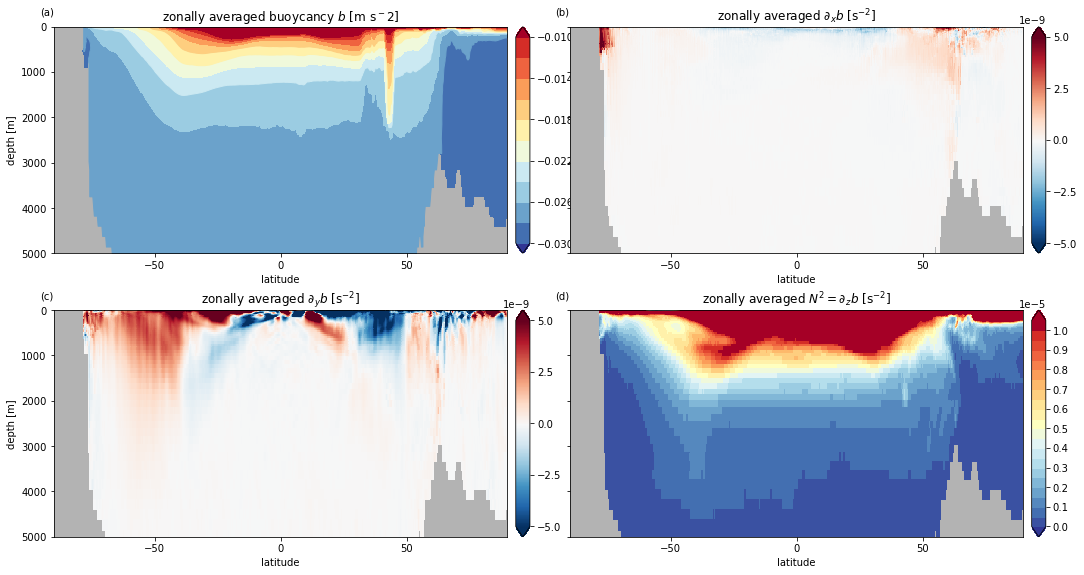

In [145]:
hca, hcb = pyic.arrange_axes(2,2, plot_cb=True, asp=0.5, fig_size_fac=2.,
                               sharex=False, sharey=True, xlabel="latitude", ylabel="depth [m]",
                            )
ii=-1

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lat, IcD.depthc, bi[:,:,:].mean(axis=2), ax=ax, cax=cax,
                clim=[-3e-2,-1e-2], contfs='21' 
               )
ax.set_title(f'zonally averaged buoycancy $b$ [m s$^{-2}$]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lat, IcD.depthc, dbdxi[:,:,:].mean(axis=2), ax=ax, cax=cax,
                clim=5e-9, 
               )
ax.set_title('zonally averaged $\partial_x b$ [s$^{-2}$]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lat, IcD.depthc, dbdyi[:,:,:].mean(axis=2), ax=ax, cax=cax,
                clim=5e-9, 
               )
ax.set_title('zonally averaged $\partial_y b$ [s$^{-2}$]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lat, IcD.depthc, N2vihi[:,:,:].mean(axis=2), ax=ax, cax=cax,
                clim=[0,1e-5], cincr=0.05e-5, 
#                 contfs=np.array([])*1e-5,
               )
ax.set_title('zonally averaged $N^2=\partial_z b$ [s$^{-2}$]')

for ax in hca:
    ax.set_ylim(5000,0)
    ax.set_facecolor('0.7')

## Plot velocity gradients

In [164]:
lon, lat, uoi = pyic.interp_to_rectgrid(uo, fpath_ckdtree, coordinates='clat clon')
lon, lat, dudxi = pyic.interp_to_rectgrid(dudx, fpath_ckdtree, coordinates='clat clon')
lon, lat, dudyi = pyic.interp_to_rectgrid(dudy, fpath_ckdtree, coordinates='clat clon')
lon, lat, dudzi = pyic.interp_to_rectgrid(dudzvi, fpath_ckdtree, coordinates='clat clon')
lon, lat, voi = pyic.interp_to_rectgrid(vo, fpath_ckdtree, coordinates='clat clon')
lon, lat, dvdxi = pyic.interp_to_rectgrid(dvdx, fpath_ckdtree, coordinates='clat clon')
lon, lat, dvdyi = pyic.interp_to_rectgrid(dvdy, fpath_ckdtree, coordinates='clat clon')
lon, lat, dvdzi = pyic.interp_to_rectgrid(dvdzvi, fpath_ckdtree, coordinates='clat clon')

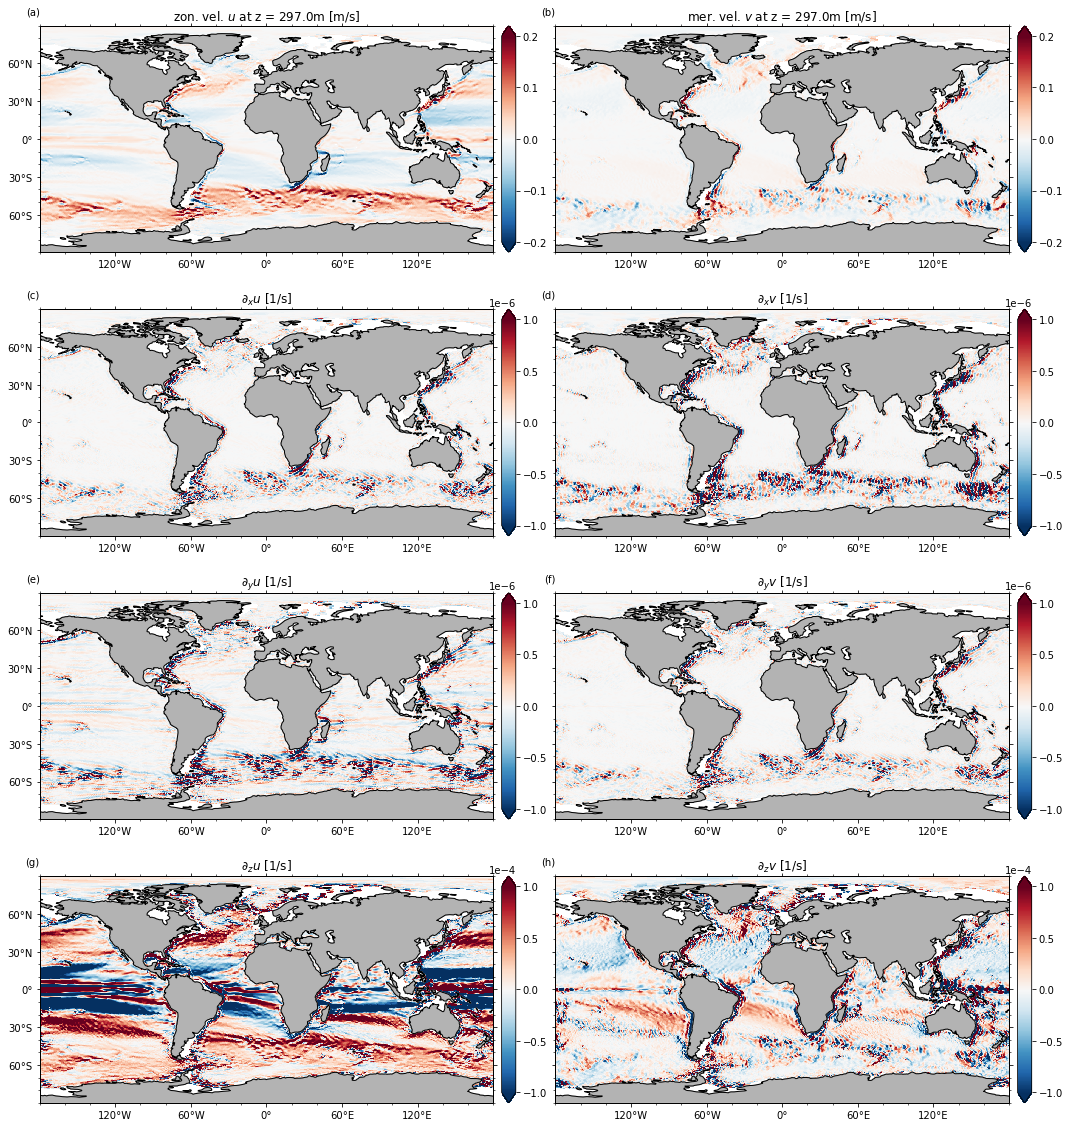

In [168]:
hca, hcb = pyic.arrange_axes(2,4, plot_cb=True, asp=0.5, fig_size_fac=2.,
                               sharex=False, sharey=True, xlabel="", ylabel="",
                               projection=ccrs_proj,
                            )
hca = hca[::2]+hca[1::2]
hcb = hcb[::2]+hcb[1::2]
ii=-1

# --- uo
ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, uoi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=0.2,
               )
ax.set_title(f'zon. vel. $u$ at z = {IcD.depthc[iz]:.1f}m [m/s]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, dudxi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=1e-6, 
               )
ax.set_title('$\partial_x u$ [1/s]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, dudyi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=1e-6, 
               )
ax.set_title('$\partial_y u$ [1/s]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, dudzi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=1e-4, 
               )
ax.set_title('$\partial_z u$ [1/s]')

# --- vo
ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, voi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=0.2,
               )
ax.set_title(f'mer. vel. $v$ at z = {IcD.depthc[iz]:.1f}m [m/s]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, dvdxi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=1e-6, 
               )
ax.set_title('$\partial_x v$ [1/s]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, dvdyi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=1e-6, 
               )
ax.set_title('$\partial_y v$ [1/s]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lon, lat, dvdzi[iz,:,:], ax=ax, cax=cax, transform=ccrs_proj,
                clim=1e-4, 
               )
ax.set_title('$\partial_z v$ [1/s]')


for ax in hca:
    pyic.plot_settings(ax, template='global')